In [13]:
import pandas as pd
import numpy as np
import matplotlib 
def getWeights(d,size):
    #thres>0 drops insignificant weights 
    w=[1.]
    for k in range(1, size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w
def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax=w.plot()
    ax.legend(loc='upper right');
    return

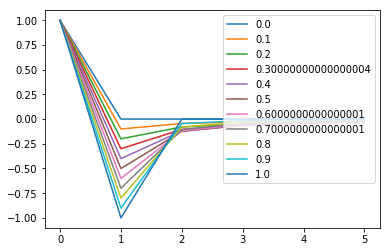

In [14]:
plotWeights(dRange=[0,1], nPlots=11,size=6)

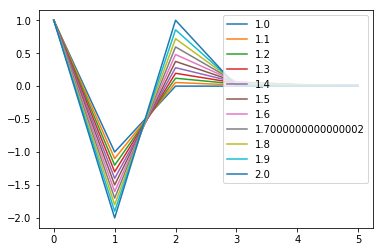

In [15]:
plotWeights(dRange=[1,2], nPlots=11,size=6)

In [18]:
#standard fracdiff with expanding window

def fracDiff(series, d, thres=.01):
    '''Increasing Width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]'''
    #1 compute weight for longest series
    w=getWeights(d, series.shape[0])
    #2 determine intitial calcs to be skipped based on weight loss threshold 
    w_ = np.cumsum(abs(w))
    w_/=w_[-1]
    skip = w_[w_>thres].shape[0]
    # apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isinfinite(series.loc[loc.name]):
                continue #exclude NAs
            df_[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc]),[0,0]
        df[name] = df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df
                

In [19]:
#fixed width window fracdiff
def getWeights_FFD(d, thres):
    w, k=[1.], 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_)<thres:
            break
        w.append(w_); k+=1
    return np.array(w[::-1]).reshape(-1,1)
def fracDiff_FFD(series, d, thres=1e-5):
    #constant width window
    w, width, df=getWeights_FFD(d,thres), len(w)-1, {}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1=seriesF.index[iloc1-width], seriesF.index[iloc1]
            if not np.isinfinite(series.loc[loc1,name]):
                continue
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df.pd.concat(df,axis=1)
    return df